## imports

In [ ]:
import os
import zipfile
import shutil
from pathlib import Path
import random
import glob
import pandas as pd
import numpy as np

import tensorflow as tf
import albumentations as A
import cv2
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns


from tensorflow import keras, TensorSpec
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.data import Dataset, experimental


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## definitions to set by user

In [ ]:
# set "machine" according to where you want to run the script

machine = 'colab' # 'colab' or 'local'

# modelname:
model_name = 'vgg16_yb_02'


IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 4
BATCH_SIZE = 16

classes = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
index_to_class =  {v: k for k, v in class_to_index.items()} # Invert the dictionary

# random number in order to reproduce the split etc.
rand_num = 42

## load directories on colab

In [3]:
if machine == 'colab':
    #from google.colab import files
    #files.upload()

    # load google drive when working on colab
    from google.colab import drive
    #drive.mount('/content/drive')
    drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## definitions

In [4]:
#####################################
# paths:
#####################################

if machine == 'local':
    # paths to load data:
    base_path = r"..\\data\\"
    base_path_zip = os.path.join(base_path, "raw")                       # path where zip-file is
    base_path_raw = base_path_zip                                        # path where raw data is unziped to  (on local machine same as path where zip is)
    base_path_processed = os.path.join(base_path, "processed", "DL")     # path where processed data is saved

    # paths to save models:
    model_path = r"..\\Models\\local\\DL"

elif machine == 'colab':
    # paths to load data:
    base_path_drive     = '/content/drive/MyDrive/data'         # base path on DRIVE
    base_path_colab     =  '/content/data'                      # base path on COLAB
    base_path_zip       = os.path.join(base_path_drive, 'raw')  # path where zip-file is (on drive)
    base_path_raw       = os.path.join(base_path_colab, 'raw')  # path where raw data is unziped to (on colab machine not on drive)
    base_path_processed = os.path.join(base_path_colab, 'processed')  # path where processed data is saved (on colab machine not on drive)


    # paths to save models:
    model_path = '/content/drive/MyDrive/models/DL'

In [5]:
archive_zip = 'covid19-radiography-database.zip'
unzipped_folder = 'COVID-19_Radiography_Dataset'

if machine == 'local':

    # only unzip if target folder not already exists:
    if not os.path.exists(os.path.join(base_path_raw,unzipped_folder)):
        with zipfile.ZipFile(os.path.join(base_path_zip, archive_zip), 'r') as zip_ref:
            for file_name in zip_ref.namelist():
                zip_ref.extract(file_name, base_path_raw)  # Extract files into target folder
            print("zip-archive {} unziped to folder: {}." .format(archive_zip, os.path.join(base_path_raw,unzipped_folder)))
    else:
        print('Nothing to unzip, folder already exist.')

elif machine == 'colab':
    # create directory
    os.makedirs(base_path_raw, exist_ok=True)
    os.makedirs(base_path_processed, exist_ok=True)

    # only unzip if target folder not already exists:
    if not os.path.exists(os.path.join(base_path_raw,unzipped_folder)):
        with zipfile.ZipFile(os.path.join(base_path_zip, archive_zip), 'r') as zip_ref:
            for file_name in zip_ref.namelist():
                zip_ref.extract(file_name, base_path_raw)  # Extract files into target folder
            print("zip-archive {} unziped to folder: {}." .format(archive_zip, os.path.join(base_path_raw,unzipped_folder)))
    else:
        print('Nothing to unzip, folder already exist.')


zip-archive covid19-radiography-database.zip unziped to folder: /content/data/raw/COVID-19_Radiography_Dataset.


## Train - test split

In [6]:
random.seed(rand_num)

# Set paths for source (downloaded data) and destination (processed train/test)
source_dir = os.path.join(base_path_raw, unzipped_folder)
dest_dir = base_path_processed

train_dir = os.path.join(dest_dir, "train_data_with_masks")
test_dir = os.path.join(dest_dir, "test_data_with_masks")

split_ratio = 0.85

for cls in classes:
    print(f"Processing class: {cls}")

    # Paths to images and masks in raw data
    images_path = os.path.join(source_dir, cls, "images")
    masks_path = os.path.join(source_dir, cls, "masks")

    # List image files only
    all_images = [img for img in os.listdir(images_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(all_images)

    split_index = int(len(all_images) * split_ratio)
    train_imgs = all_images[:split_index]
    test_imgs = all_images[split_index:]

    # Create destination directories
    train_img_dir = os.path.join(train_dir, cls, "images")
    train_mask_dir = os.path.join(train_dir, cls, "masks")
    test_img_dir = os.path.join(test_dir, cls, "images")
    test_mask_dir = os.path.join(test_dir, cls, "masks")

    os.makedirs(train_img_dir, exist_ok=True)
    os.makedirs(train_img_dir, exist_ok=True)
    os.makedirs(train_mask_dir, exist_ok=True)
    os.makedirs(test_img_dir, exist_ok=True)
    os.makedirs(test_mask_dir, exist_ok=True)

    # Copy images and corresponding masks
    for img in train_imgs:
        shutil.copy(os.path.join(images_path, img), os.path.join(train_img_dir, img))
        mask_file = os.path.join(masks_path, img)
        if os.path.exists(mask_file):
            shutil.copy(os.path.join(mask_file), os.path.join(train_mask_dir, img))

    for img in test_imgs:
        shutil.copy(os.path.join(images_path, img), os.path.join(test_img_dir, img))
        mask_file = os.path.join(masks_path, img)
        if os.path.exists(mask_file):
            shutil.copy(mask_file, os.path.join(test_mask_dir, img))

    print(f"  Copied {len(train_imgs)} images (and masks if available) to {train_img_dir}")
    print(f"  Copied {len(test_imgs)} images (and masks if available) to {test_img_dir}")


Processing class: Normal
  Copied 8663 images (and masks if available) to /content/data/processed/train_data_with_masks/Normal/images
  Copied 1529 images (and masks if available) to /content/data/processed/test_data_with_masks/Normal/images
Processing class: COVID
  Copied 3073 images (and masks if available) to /content/data/processed/train_data_with_masks/COVID/images
  Copied 543 images (and masks if available) to /content/data/processed/test_data_with_masks/COVID/images
Processing class: Lung_Opacity
  Copied 5110 images (and masks if available) to /content/data/processed/train_data_with_masks/Lung_Opacity/images
  Copied 902 images (and masks if available) to /content/data/processed/test_data_with_masks/Lung_Opacity/images
Processing class: Viral Pneumonia
  Copied 1143 images (and masks if available) to /content/data/processed/train_data_with_masks/Viral Pneumonia/images
  Copied 202 images (and masks if available) to /content/data/processed/test_data_with_masks/Viral Pneumonia/

## resplit the train set into train (80%) and validation (20%) set

In [ ]:
# data_dir = train_dir

# all_img_paths = []
# all_class_indices = []

# for class_name in classes:
#     class_dir = os.path.join(data_dir, class_name, "images")
#     img_files = glob.glob(f"{class_dir}/*.png")
#     for img_file in img_files:
#         all_img_paths.append(str(img_file))
#         all_class_indices.append(class_to_index[class_name])

# # Train/val split
# train_imgs, val_imgs, train_labels, val_labels = train_test_split(
#     all_img_paths, all_class_indices, test_size=0.2, stratify=all_class_indices, random_state=rand_num
# )

## augmentation and train_val split

In [ ]:
import tensorflow as tf
import albumentations as A
import cv2
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 4
BATCH_SIZE = 16

classes = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
CLASS_TO_INDEX = {cls: idx for idx, cls in enumerate(classes)}

DATA_DIR = train_dir

# Albumentations augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, p=0.5),
])

# ----------- Dataset Preparation -----------

all_img_paths = []
all_class_indices = []

for class_name in classes:
    class_dir = os.path.join(DATA_DIR, class_name, "images")
    #img_files = list(class_dir.glob("*"))
    img_files = glob.glob(f"{class_dir}/*.png")
    for img_file in img_files:
        all_img_paths.append(str(img_file))
        all_class_indices.append(CLASS_TO_INDEX[class_name])

# Train/val split
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_img_paths, all_class_indices, test_size=0.2, stratify=all_class_indices, random_state=42
)

# ----------- Data Generator -----------

def load_classification_image(img_path, label, augment_data=False):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    if augment_data:
        img = augment(image=img)['image']

    img = img.astype(np.float32) / 255.0
    img = np.stack([img]*3, axis=-1)  # convert grayscale to RGB
    return img, label

def classification_generator(img_paths, labels, augment_data=False):
    for img_path, label in zip(img_paths, labels):
        img, lbl = load_classification_image(img_path, label, augment_data=augment_data)
        yield img, lbl

def create_classification_dataset(img_paths, labels, batch_size=16, augment=False):
    dataset = tf.data.Dataset.from_generator(
        lambda: classification_generator(img_paths, labels, augment_data=augment),
        output_signature=(
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    if augment:
        dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = create_classification_dataset(train_imgs, train_labels, batch_size=BATCH_SIZE, augment=True)
val_ds = create_classification_dataset(val_imgs, val_labels, batch_size=BATCH_SIZE, augment=False)

print(f"Train batches: {len(list(train_ds))}")
print(f"Validation batches: {len(list(val_ds))}")

## prepare test data

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
from pathlib import Path

TEST_DATA_DIR = Path("/content/data/processed/test_data_with_masks")

X_test_raw = []
y_test_raw = []

for cls_index, cls_name in enumerate(classes):
    img_dir = TEST_DATA_DIR / cls_name / "images"
    img_files = list(img_dir.glob("*"))

    for img_file in img_files:
        img = load_img(img_file, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
        img_array = img_to_array(img).astype(np.float32) / 255.0
        img_array = np.repeat(img_array, repeats=3, axis=-1)  # Convert grayscale to RGB

        X_test_raw.append(img_array)
        y_test_raw.append(cls_index)  # Image-level class label

# Convert to NumPy arrays
X_test = np.array(X_test_raw, dtype=np.float32)
y_test = np.array(y_test_raw, dtype=np.int32)

print("X_test shape:", X_test.shape)  # (N, 224, 224, 3)
print("y_test shape:", y_test.shape)  # (N,)

number of images per class after augmentation:
2    8176
1    7374
3    7320
0    6930
Name: count, dtype: int64


In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## create tensors: train, validation

In [ ]:
# # ----------- Data Generator -----------

# def load_classification_image(img_path, label):
#     img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

#     img = img.astype(np.float32) / 255.0
#     img = np.stack([img]*3, axis=-1)  # convert grayscale to RGB
#     return img, label

# def classification_generator(img_paths, labels):
#     for img_path, label in zip(img_paths, labels):
#         img, lbl = load_classification_image(img_path, label)
#         yield img, lbl

# def create_classification_dataset(img_paths, labels, batch_size):
#     dataset = tf.data.Dataset.from_generator(
#         lambda: classification_generator(img_paths, labels),
#         output_signature=(
#             tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
#             tf.TensorSpec(shape=(), dtype=tf.int32)
#         )
#     )
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(tf.data.AUTOTUNE)
#     return dataset

# train_ds = create_classification_dataset(train_imgs, train_labels, batch_size=BATCH_SIZE)
# val_ds = create_classification_dataset(val_imgs, val_labels, batch_size=BATCH_SIZE)

# print(f"Train batches: {len(list(train_ds))}")
# print(f"Validation batches: {len(list(val_ds))}")

Train batches: 1863
Validation batches: 225


## create tensors: test

In [ ]:
# from tensorflow.keras.utils import load_img, img_to_array
# import numpy as np
# from pathlib import Path

# TEST_DATA_DIR = test_dir

# X_test_raw = []
# y_test_raw = []

# for cls_index, cls_name in enumerate(classes):
#     img_dir = os.path.join(TEST_DATA_DIR, cls_name, "images")
#     img_files = glob.glob(f"{img_dir}/*.png")

#     for img_file in img_files:
#         img = load_img(img_file, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
#         img_array = img_to_array(img).astype(np.float32) / 255.0
#         img_array = np.repeat(img_array, repeats=3, axis=-1)  # Convert grayscale to RGB

#         X_test_raw.append(img_array)
#         y_test_raw.append(cls_index)  # Image-level class label

# # Convert to NumPy arrays
# X_test = np.array(X_test_raw, dtype=np.float32)
# y_test = np.array(y_test_raw, dtype=np.int32)

# print("X_test shape:", X_test.shape)  # (N, 224, 224, 3)
# print("y_test shape:", y_test.shape)  # (N,)


# test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


X_test shape: (3176, 299, 299, 3)
y_test shape: (3176,)


## display some images

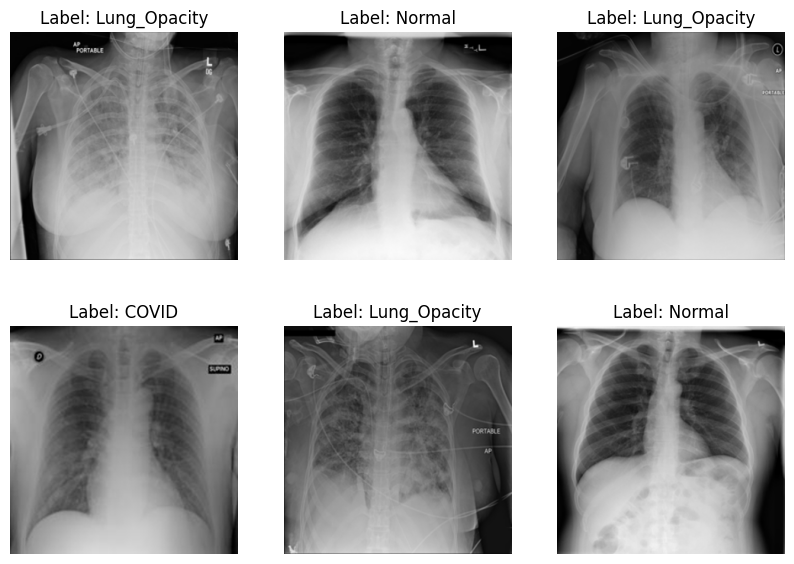

In [15]:
# Define the number of images to display
number_of_images = 6

# Create a figure for displaying
plt.figure(figsize=(10,7))

# Get a batch of images from train_ds
for batch, labels in train_ds.take(1):
    # Display the images from the batch
    for i in range(number_of_images):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(batch[i].numpy())  # Convert the image to integer for display
        plt.axis("off")
        plt.title(f"Label: {index_to_class[labels[i].numpy()]}")

# Show the images
plt.show()

# Modelling

## define the model

In [ ]:
# Load VGG16 base without top
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze VGG16 layers

# Input
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Pass input through VGG16

# Classification head
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(5, activation='softmax')(x)  # 5 classes (adjust if needed)


## Compile the model



In [ ]:
# Build and compile model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,590,500 (93.81 MB)

 Trainable params: 2,787,716 (10.63 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
from tensorflow.keras.utils import plot_model

# Update this path to your desired Google Drive folder
save_path = os.path.join(model_path, model_name + '_model_design.png')

plot_model(model, to_file=save_path, show_shapes=True, show_layer_names=True)
print(f"Model plot saved to: {save_path}")

In [ ]:
# ## define steps per epoche:
# steps_per_epoch = len(train_imgs) // BATCH_SIZE  # Total samples / batch size
# validation_steps = len(val_imgs) // BATCH_SIZE


# # --- Callbacks ---
# #early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# early_stopping = EarlyStopping(
#     monitor = 'val_loss',
#     min_delta = 0.01,   # If the loss function doesn't change by 1% after 5 epochs, either up or down, we stop
#     patience = 5,       # Wait for 5 epochs before applying
#     verbose = 1,        # to display the epoch at which training stops
#     mode = 'min',
#     restore_best_weights=True
# )

# reduce_learning_rate = ReduceLROnPlateau(
#     monitor = 'val_loss',
#     min_delta = 0.01,
#     patience = 3,         # If val_loss stagnates for 3 consecutive epochs based on the min_delta value
#     factor = 0.1,         # Reduce the learning rate by a factor of 0.1
#     cooldown = 4,         # Wait 4 epochs before retrying
#     verbose = 1
# )

# save = ModelCheckpoint(os.path.join(model_path, model_name + ".keras"),
#                                 save_best_only=True,
#                                 monitor='val_accuracy',
#                                 mode='min')



# # --- Train model ---
# history = model.fit(train_ds,
#     validation_data=val_ds,
#     epochs=25,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps,
#     #callbacks=[early_stopping, save]
#     callbacks=[save]
# )

EPOCHS = 5
steps_per_epoch = len(train_imgs) // BATCH_SIZE
validation_steps = len(val_imgs) // BATCH_SIZE

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

Epoch 1/25
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 130s 70ms/step - accuracy: 0.4409 - loss: 1.2330 - val_accuracy: 0.0636 - val_loss: 4.0709
Epoch 2/25
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.0000e+00 - loss: 1.1142 - val_accuracy: 0.0636 - val_loss: 4.0501
Epoch 3/25
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 127s 68ms/step - accuracy: 0.4424 - loss: 1.2531 - val_accuracy: 0.0636 - val_loss: 4.1197
Epoch 4/25
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.0000e+00 - loss: 1.1398 - val_accuracy: 0.0636 - val_loss: 4.0966
Epoch 5/25
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 127s 68ms/step - accuracy: 0.4427 - loss: 1.2491 - val_accuracy: 0.0681 - val_loss: 4.3845
Epoch 6/25
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.0000e+00 - loss: 1.1425 - val_accuracy: 0.0686 - val_loss: 4.3791
Epoch 7/25
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 127s 68ms/step - accuracy: 0.4443 - loss: 1.2699 - val_accuracy: 0.0636 - val_loss: 4.2871
Epoch 8/25
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accura

## Evaluation

In [ ]:
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]:.4f} - Test Accuracy: {results[1]:.4f}")

In [ ]:
# Save in the Keras format (recommended in TF 2.x)
model.save(os.path.join(model_path, model_name + ".keras"))

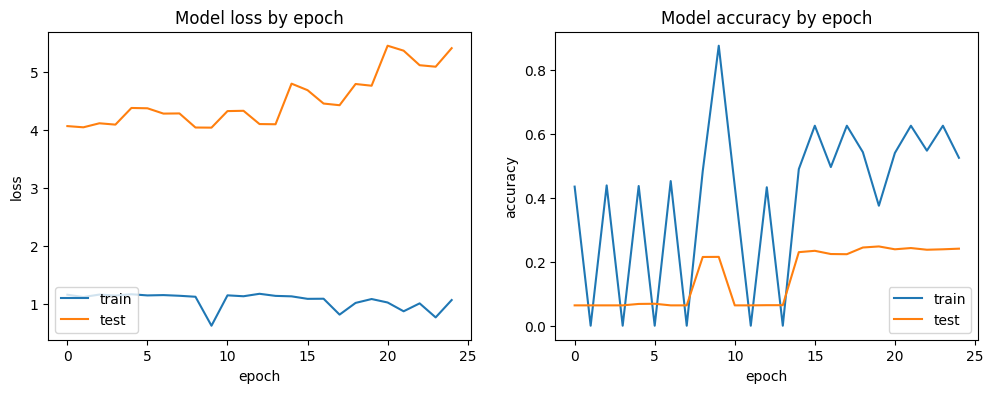

In [31]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



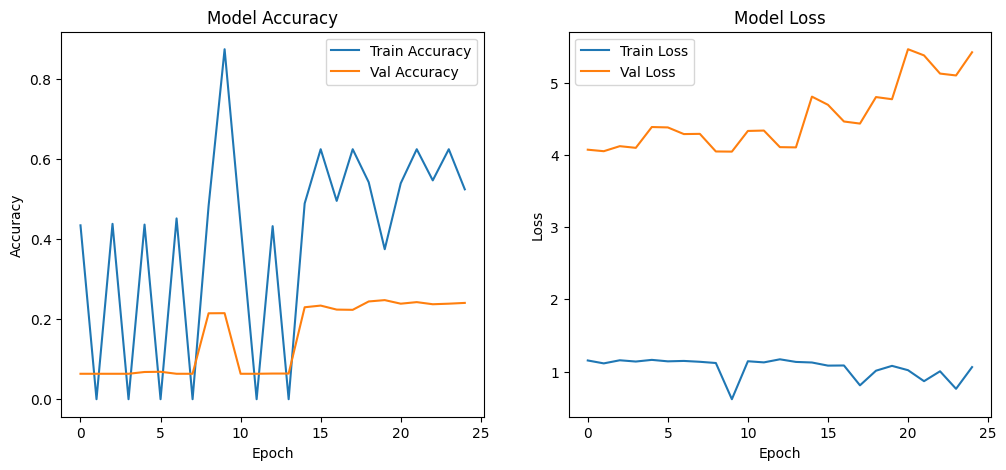

In [32]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Predict probabilities
y_pred_probs = model.predict(test_ds)

# Convert probs to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # shape: (num_samples,)

y_true = y_test 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1529
           1       0.20      0.96      0.33       543
           2       0.36      0.07      0.12       902
           3       0.43      0.91      0.58       202

    accuracy                           0.24      3176
   macro avg       0.25      0.48      0.26      3176
weighted avg       0.16      0.24      0.13      3176



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

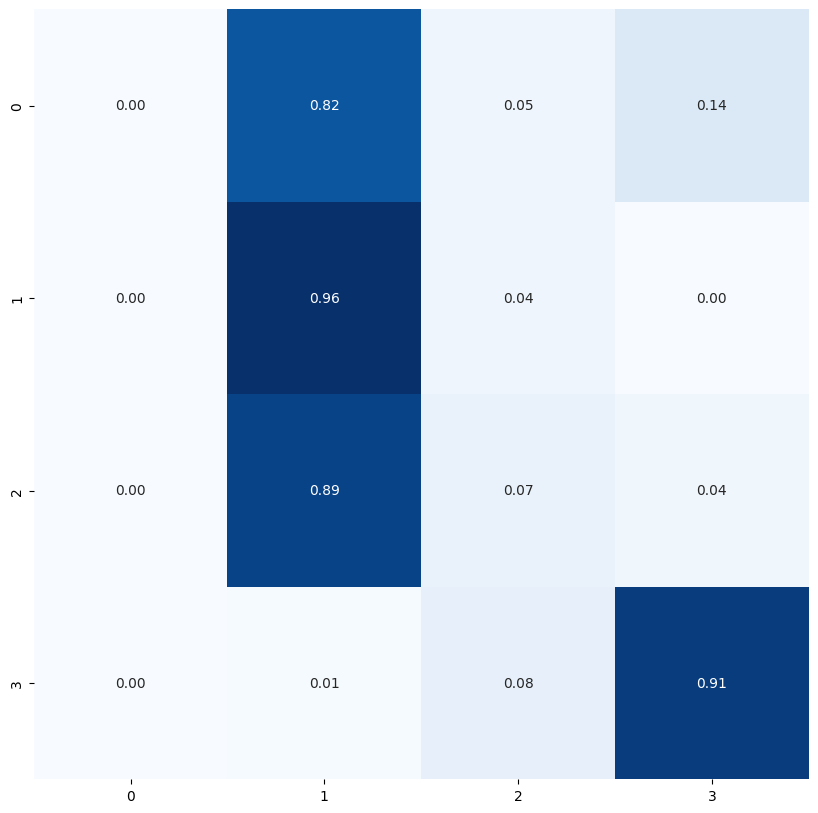

In [ ]:
# def get_predictions_and_labels(dataset):
#     true_labels = []
#     pred_labels = []

#     for images, labels in dataset:

#         preds = model.predict(images, verbose=0)  # Get the model's predictions
#         pred_labels.extend(np.argmax(preds, axis=-1))  # Get the predicted labels (argmax)
#         #pred_labels.extend(preds)  # Get the predicted labels (argmax)

#         true_labels.extend(labels.numpy())  # Get the true labels

#     return np.array(true_labels), np.array(pred_labels)

# y_true, y_pred = get_predictions_and_labels(test_ds)  # Get true labels and predictions from the test dataset



                 precision    recall  f1-score   support

         Normal       0.00      0.00      0.00      1529
          COVID       0.20      0.96      0.33       543
   Lung_Opacity       0.36      0.07      0.12       902
Viral Pneumonia       0.43      0.91      0.58       202

       accuracy                           0.24      3176
      macro avg       0.25      0.48      0.26      3176
   weighted avg       0.16      0.24      0.13      3176



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


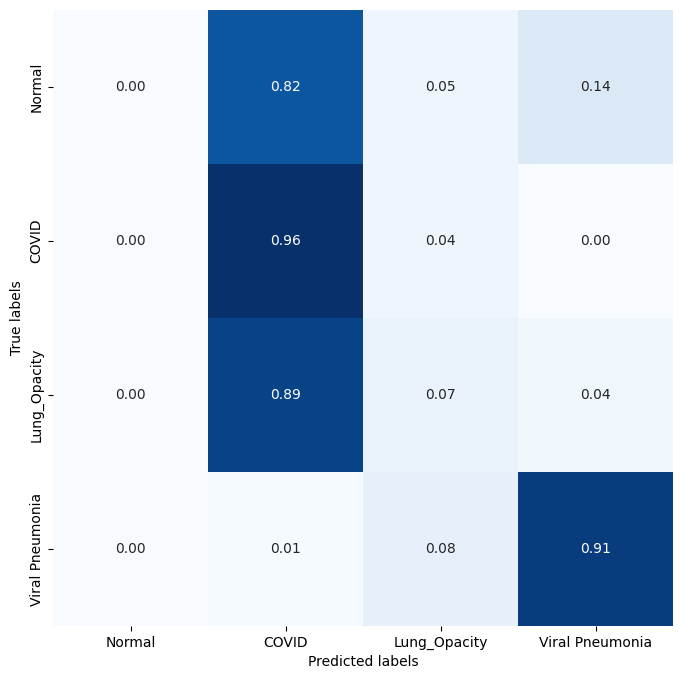

In [42]:
# Display the classification report
print(classification_report(y_true, y_pred, target_names=classes))  # Print the classification report (precision, recall, F1-score)

# Display the confusion matrix
plt.figure(figsize=(8, 8))  # Create a large figure for the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')  # Compute the normalized confusion matrix

sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False, fmt=".2f", xticklabels=classes, yticklabels=classes)  # Plot the confusion matrix as a heatmap
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()